In [7]:
import torch
import torch.nn as nn
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from rendering import rendering

In [3]:
from dataset import get_rays

# Camera/Dataset

In [4]:
batch_size = 1024
o, d, t = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o),
                                    torch.from_numpy(d),
                                     torch.from_numpy(t)), dim=1), batch_size=batch_size, shuffle=True)


test_o, test_d, test_t = get_rays('fox', mode='test')

In [5]:
test_o.shape

(10, 160000, 3)

In [6]:
# so we can say we have 10 test images and 400*400 images and 3 dimension

# Rendering

# Model

In [37]:
class Voxels(nn.Module):

    def __init__(self):
        super(Voxels, self).__init__()

    def forward(self, x):
        pass

    def intersect(self, x):
        pass

In [41]:
class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()
        
        self.voxels = torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), 
                                                    device=device)
        
        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale
        
    def forward(self, xyz):
        
        x = xyz[:, 0] #all the points in first dimension of xyz tensor 
        y = xyz[:, 1] # all the points in second(y) dimension of xyz tensor
        z = xyz[:, 2]
        
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))
        
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = torch.tensor([1., 0 ,0])
        colors_and_densities[cond, -1] = 10
         
        return colors_and_densities[:, :3], colors_and_densities[:, -1:]
        
    
    def intersect(self, x):
       return self.forward(x)




In [42]:
model = Voxels()

In [43]:
img = rendering(model, torch.from_numpy(o[0]), torch.from_numpy(d[0]), 8, 12)

In [44]:
o.shape

(90, 160000, 3)

In [45]:
d.shape

(90, 160000, 3)

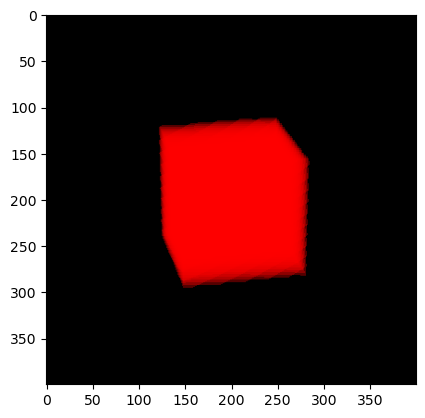

In [48]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

In [49]:
model = Voxels(scale=1.5)

In [50]:
img = rendering(model, torch.from_numpy(o[0]), torch.from_numpy(d[0]), 8, 12)

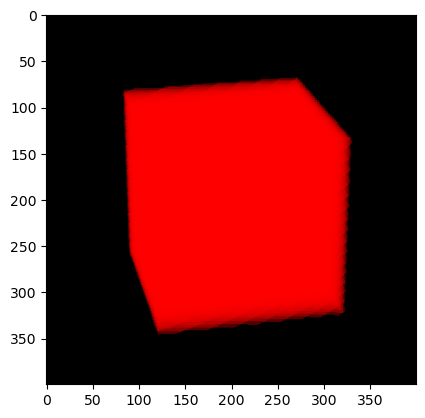

In [51]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

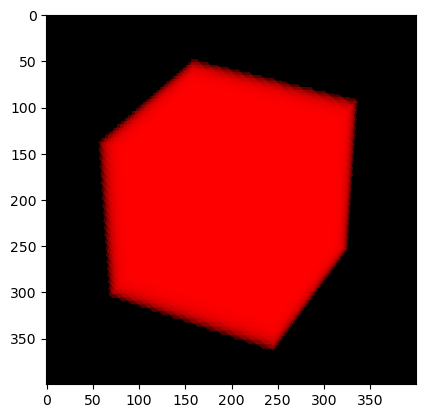

In [55]:
#now if we change the orgin and the direction of the ray we can see a different viewing angle
img = rendering(model, torch.from_numpy(o[1]), torch.from_numpy(d[1]), 8, 12)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

In [74]:
class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()
        
        self.voxels = torch.nn.Parameter(torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), 
                                                    device=device, requires_grad=True))
        
        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale
        
    def forward(self, xyz):
        
        x = xyz[:, 0] #all the points in first dimension of xyz tensor 
        y = xyz[:, 1] # all the points in second(y) dimension of xyz tensor
        z = xyz[:, 2]
        
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))

        indx = (x[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)  #this is for getting the x of the fox in the voxels
        indy = (y[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long) 
        indz = (z[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)

        
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = self.voxels[indx, indy, indz, :3]
        colors_and_densities[cond, -1] = self.voxels[indx, indy, indz, -1] * 100
         
        return colors_and_densities[:, :3], colors_and_densities[:, -1:]
        
    
    def intersect(self, x):
       return self.forward(x)


In [75]:
model = Voxels()

In [76]:
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

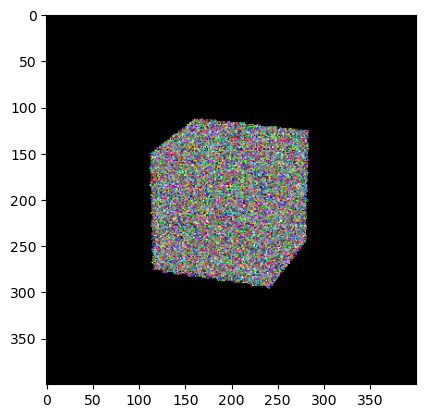

In [77]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

In [78]:
class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()
        
        self.voxels = torch.nn.Parameter(torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), 
                                                    device=device, requires_grad=True))
        
        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale
        
    def forward(self, xyz, d):
        
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]
        
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))
        
        indx = (x[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indy = (y[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indz = (z[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = self.voxels[indx, indy, indz, :3]
        colors_and_densities[cond, -1] = self.voxels[indx, indy, indz, -1]
         
        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1:])
        
    
    def intersect(self, x, d):
        return self.forward(x, d)


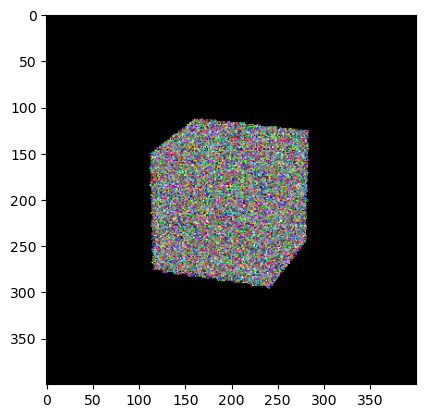

In [80]:
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

# Training